<a href="https://colab.research.google.com/github/laura314159265/poly/blob/main/PR%C3%80CTICA_GUIADA/Crank_em_vull_matar_Nicolson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [177]:
import numpy as np

def gauss_seidel(A, b, x0, err):
    #Resol una equació lineal algebraica de l'estil Ax=b on A matriu b i x vectors
    #el vector x és el de les incògnites

    n = len(A[0])
    x = x0.copy() # Copiem x0 per evitar que x0 i x apuntin al mateix objecte i evitar que quan modifiquis un es modifiqui també l'altre

    while True:
        x_ant = x.copy()
        for i in range(n):
            sum1 = np.dot(A[i, :i], x[:i]) # Part del sumatori que utilitza els x_i+1 (nous ja calculats)
            sum2 = np.dot(A[i, i+1:], x_ant[i+1:]) # Part del sumatori que utilitza els x_1 ("anteriors")

            # Ens assegurem que la diagonal de A to tingui 0 (per evitar dividir per 0 en l'esquema d'iteració)
            if A[i, i] == 0:
                print ("Algun element de la diagonal de A és 0")
                break
            x[i] = (b[i] - sum1 - sum2) / A[i, i]

        # Mirem la convergència tal com hem vist a teoria
        if np.abs(max(x - x_ant)) < err: #on err és l'error màxim que tolerem
            return np.array(x)

Bueno toca Crank-Nicolson  \
Si fas com derivades numèriques i reordenes queda:
$T_{i+1}^n (1+2\gamma)-\gamma·T_{i+1}^{n+1}-\gamma · T_{i+1}^{n-1} = T_i^n + \gamma · T_i^{n+1} + \gamma ·T_i
^{n-1} + Δt$\
que es pot escriure com un sistema de matrius to jodido pero bueno tenim llibreries\
Tenim dues matrius tridiagonals.\
 La de l'esquerre, matriu A, te per offdiagonal $-\gamma$ i per diagonal $(1+2\gamma)$ i multiplica un vector de les T a temps i+1\
 La de la dreta, matriu B, te per offdiagonal $\gamma$ i per diagonal $(1-2\gamma)$ i multiplica un vector de les T a temps i i li suma $Δt$\
 Necessitem puto invertir la matriu de l'esquerre, multiplicar tot a la dreta per l'inversa i tenim el vector d'incognites aïllat amb coses que coneixem (vamos que tenim el sistema resolt)

In [178]:
import numpy as np
from scipy.linalg import toeplitz
from numpy.linalg import inv
import matplotlib.pyplot as plt
import matplotlib.patches as pt

#definim matriu A
C_v= 3686
rho= 1081
kappa= 0.56
sigma= 0.472
volts= 40

#definim variables i demés constants:
alpha_var= kappa/(C_v*rho) #es la difusivitat

N= 101   # Mallat espaial, nombre de punts que tenim
x_0= 0.02 #Donat a classe, és la longitud de referència que usarem per la normalització
x_f= 0.02/x_0 #normalitzada, ja que \tilde{x}=x/x_0
x_i= 0
t_i= 0
t_0= x_0**2/alpha_var #surt de la normalització de l'equació diferencial
t_f= 0.025 #ja està normalitzat, ho diu l'enunciat

P_ext= volts**2*sigma/(2*(x_0)**2) #calculada per anàlisi dimensional a partir de dades proporcionades, el factor 2 dividint és perquè s'ha d'agafar el voltatge efectiu
T_0= P_ext/(C_v*rho)*t_0 #és la temperatura, en kelvin, que utilitzarem per la normalització. S'obté d'utilitzar t_0
print("T_0=",T_0,"k")
T_init= 309.65/T_0   #temperatura inicial normalitzada
print("T_init (JA NORMALITZADA)=",T_init,"k")

dx=x_f/(N-1) #valor de les particions espacials donat un nombre N de nodes espacials
dt_1= dx**2 #primer cas a considerar
dt_2= 0.5*dx**2 #segon cas a considerar

def CN(N, T_i, t_f, dt, dx):
  """
    N = int, nombre de nodes espaials
    T_i = float, temperatura inicial normalitzada
    t_f = float, temps final normalitzat
    dt = float, partició temporal
    dx = dx, partició espaial
  """
  gamma= dt/(2*dx**2) #variable per simplificar notació

  dt_vect= np.ones((N-2,1))*dt
  dt_vect[0]= 2*gamma*T_i + dt
  dt_vect[-1]= 2*gamma*T_i + dt  #Vector dels dts que queden sumant a la solució

  T_i_vect = np.ones((N-2,1))*T_i
  fila1_A= (N-2)*[0]
  fila1_A [0]= 1+2*gamma
  fila1_A [1]= -gamma
  col_A = (N-2)*[0]
  col_A [1]= -gamma
  A = toeplitz(fila1_A,col_A) #Funció que crea una matriu tridiagonal a partir de la primera fila i columna

  fila1_B= (N-2)*[0]
  fila1_B [0]= 1-2*gamma
  fila1_B [1]= gamma
  col_B = (N-2)*[0]
  col_B [1]= gamma
  B = toeplitz(fila1_B,col_B)   #Una altra matriu tridiagonal

  inicial= np.array(99*[T_init])  #Creem el nostre primer vector columna per
                                  #gauss-seidel a partir de la condició inicial
                                  #de temperatura (és bona aproximació)

  t_i = 0

  while t_i < t_f:    #Bucle del càlcul del mètode de Crank-Nicolson, s'atura al arribar al temps final
    b = np.matmul(B, T_i_vect) + dt_vect  #Terme independent per Gauss-Seidel de l'equació Ax=b
    T_i_vect = gauss_seidel(A, b, T_i_vect, 1e-8)   #Cridem la funció gauss-seidel per trobar el temps següent
    t_i +=dt          #Pas del temps

  T_i_vect = T_i_vect*T_0-273.15
  T_i_vect =np.append(T_i_vect,[36.5])
  T_i_vect =np.append([36.5],T_i_vect)
  return T_i_vect

#pel primer cas tenim que delta t = delta x **2 --> gamma1 = 1/2
#pel segon tenim que delta t = 1/2 delta x**2 --> gamma2=1/4

T1=CN(101,T_init,t_f,dt_1,dx)
T2=CN(101,T_init,t_f,dt_2,dx)

print (T1)
print (T2)

T_0= 674.2857142857143 k
T_init (JA NORMALITZADA)= 0.4592266949152542 k
[36.5        37.67197108 38.77891465 39.82322634 40.80729221 41.73348408
 42.60415485 43.42163407 44.18822352 44.90619299 45.5777763  46.20516741
 46.79051686 47.33592837 47.84345574 48.31509998 48.75280677 49.15846411
 49.53390036 49.88088246 50.20111452 50.49623666 50.76782412 51.01738663
 51.2463681  51.45614645 51.64803381 51.8232768  51.98305713 52.12849228
 52.26063646 52.38048161 52.48895859 52.58693847 52.67523388 52.75460043
 52.82573823 52.88929333 52.94585926 52.99597855 53.04014411 53.07880072
 53.11234632 53.14113331 53.1654697  53.18562017 53.20180704 53.21421104
 53.22297204 53.22818956 53.22992316 53.22819266 53.22297824 53.21422036
 53.2018195  53.18563581 53.16548855 53.14115541 53.11237172 53.07882946
 53.04017625 52.99601413 52.94589835 52.88933597 52.82578447 52.75465032
 52.67528744 52.58699573 52.48901957 52.3805463  52.26070485 52.12856434
 51.9831328  51.82335601 51.64811645 51.45623239 51.

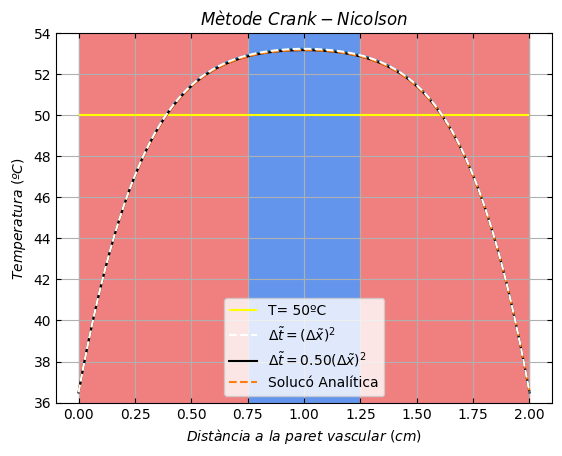

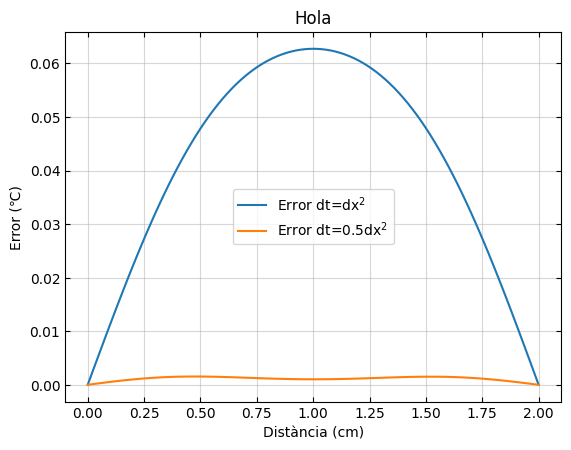

In [179]:

fig, ax= plt.subplots()

x=np.linspace(0,2,101)
ax.plot(x,T1)

#vale pillem només l'array per no executar again
T_real_analitica =[36.5, 37.66969107552376, 38.774358434195335, 39.81640154529612, 40.79821064375386, 41.72216161151641, 42.590611364820006, 43.40589332815745, 44.17031304193472, 44.88614393046629, 45.55562325343692, 46.180948261775995, 46.76427257678938, 47.307702809179034, 47.813295432258144, 48.28305392123838, 48.71892616796447, 49.12280217792255, 49.496512053786034, 49.84182426721014, 50.16044421807828, 50.45401307796095, 50.72410691220182, 50.97223607281086, 51.19984485225365, 51.40831138628192, 51.59894779218382, 51.77300052724229, 51.931650950796836, 52.0760160721066, 52.207149465221676, 52.32604233127694, 52.433624688043835, 52.53076666618608, 52.6182798914777, 52.6969189322416, 52.76738279144132, 52.83031642321015, 52.886312254103814, 52.93591169002019, 52.979606590514436, 53.01784069315329, 53.05101097157308, 53.07946891202897, 53.1035216944332, 53.12343326516634, 53.139425290298334, 53.15167797926523, 53.16033077050395, 53.165482872043015, 53.16719365156882, 53.165482872043015, 53.16033077050395, 53.15167797926523, 53.139425290298334, 53.12343326516634, 53.1035216944332, 53.07946891202897, 53.05101097157308, 53.01784069315329, 52.979606590514436, 52.93591169002019, 52.886312254103814, 52.83031642321015, 52.76738279144132, 52.6969189322416, 52.6182798914777, 52.53076666618608, 52.433624688043835, 52.32604233127694, 52.207149465221676, 52.0760160721066, 51.931650950796836, 51.77300052724229, 51.59894779218382, 51.40831138628192, 51.19984485225365, 50.97223607281086, 50.72410691220182, 50.45401307796095, 50.16044421807828, 49.84182426721014, 49.496512053786034, 49.12280217792255, 48.718926167964526, 48.28305392123838, 47.813295432258144, 47.307702809179034, 46.76427257678938, 46.180948261775995, 45.55562325343692, 44.88614393046629, 44.17031304193472, 43.40589332815745, 42.590611364820006, 41.72216161151641, 40.79821064375386, 39.81640154529612, 38.774358434195335, 37.66969107552376, 36.5]

lim_inf_y= float(np.floor(min(T1)))
altura= float(np.floor(max(T1)+1)-np.floor(min(T1)))

rectangle_cor= pt.Rectangle((0.75, lim_inf_y), 0.5, altura, color="cornflowerblue", alpha=1)
rectangle_esq= pt.Rectangle((0, lim_inf_y), 0.75, altura, color="lightcoral", alpha=1)
rectangle_dre= pt.Rectangle((1.25, lim_inf_y), 0.75, altura, color="lightcoral", alpha=1)

ax.add_patch(rectangle_cor)
ax.add_patch(rectangle_esq)
ax.add_patch(rectangle_dre)

plt.title(r"$Mètode\ Crank-Nicolson$")
plt.xlabel(r"$Distància\ a\ la\ paret\ vascular\ (cm)$")
plt.ylabel(r"$Temperatura\ (ºC)$")

ax.tick_params(direction='in', top=True, right=True)
plt.ylim(lim_inf_y, np.floor(max(T1)+1))
plt.hlines(50, 0, 2, color="yellow", label="T= 50ºC")

plt.plot(x, T1, color="white", label=r"$\Delta \tilde{t}= (\Delta \tilde{x})^2$", linestyle="--",zorder= 10)
plt.plot(x, T2, color="k", label=r"$\Delta \tilde{t}= 0.50(\Delta \tilde{x})^2$")
plt.plot(x, T_real_analitica, "--", label="Solucó Analítica",zorder=8)
plt.legend()
plt.grid("equal")
plt.show()

plt.figure()
plt.plot(x, np.abs(T1-T_real_analitica), label="Error dt=dx$^2$")
plt.plot(x, np.abs(T_real_analitica - T2), label="Error dt=0.5dx$^2$")
plt.xlabel("Distància (cm)")
plt.ylabel("Error (℃)")
plt.grid(True, alpha=0.5)
plt.title("Hola")
plt.legend()
plt.tick_params(direction='in', top=True, right=True)
plt.show()